<a href="https://colab.research.google.com/github/vaibhav251999/bike-sharing-demand-prediction/blob/main/vaibhav_Bike_Sharing_Demand_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Seoul Bike Sharing Demand Prediction </u></b>

## <b> Problem Description </b>

### Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 7.0 MB/s 


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()

from skopt import BayesSearchCV
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from time import time
from sklearn.metrics import r2_score
import xgboost as xgb

from sklearn.model_selection import cross_val_score

In [6]:
path='/content/drive/MyDrive/Almabetter/capstone projects/Bike  Sharing  Demand Prediction /Data & Resources/SeoulBikeData.csv'
df=pd.read_csv(path, encoding = 'unicode_escape')
df.head(4)


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [7]:
df.shape

(8760, 14)


## **Basic Data Exploration**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

clearly no null values ,

## <b> Data Description </b>

### <b> The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.</b>


### <b>Attribute Information: </b>

* ### Date : year-month-day
* ### Rented Bike count - Count of bikes rented at each hour
* ### Hour - Hour of he day
* ### Temperature-Temperature in Celsius
* ### Humidity - %
* ### Windspeed - m/s
* ### Visibility - 10m
* ### Dew point temperature - Celsius
* ### Solar radiation - MJ/m2
* ### Rainfall - mm
* ### Snowfall - cm
* ### Seasons - Winter, Spring, Summer, Autumn
* ### Holiday - Holiday/No holiday
* ### Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

In [9]:
# checking the duplicate values if there in the dataset
print(f'we have {len(df[df.duplicated()])} duplicate values')

we have 0 duplicate values


In [10]:
# cheking for the null values
df.isna().sum().sum()

0

*   **We have 0 null values**

*   **We have 0 duplicate values**


## **Converting date column in proper data type**

In [11]:
# checking the type of date as from the data.info() we got to know that its an object type 
type(df['Date'][0])

str

In [12]:
# converting date variable in to datetime datatype
from datetime import datetime as dt
df['Date'] = df['Date'].apply(lambda x: dt.strptime(x,'%d/%m/%Y'))

In [13]:
# checking the type  again for confirming 
type(df['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [14]:
# checking the unique values
df.nunique()

Date                          365
Rented Bike Count            2166
Hour                           24
Temperature(°C)               546
Humidity(%)                    90
Wind speed (m/s)               65
Visibility (10m)             1789
Dew point temperature(°C)     556
Solar Radiation (MJ/m2)       345
Rainfall(mm)                   61
Snowfall (cm)                  51
Seasons                         4
Holiday                         2
Functioning Day                 2
dtype: int64

 **Seasons , Holiday and Functioning Day are categorical variables**

In [15]:
df.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


**we can notice soloar radiation , rainfall and snowfall are highly positively skewed**

In [16]:
# Renaming the columns
df.rename(columns= {'Date':'date','Rented Bike Count': 'rented_bike_count', 'Hour':'hour',
                    'Temperature(°C)':'temp', 'Humidity(%)':'humidity',
                    'Wind speed (m/s)': 'wind_speed', 'Visibility (10m)': 'visibility',
                    'Dew point temperature(°C)':'dew_point_temp',
                    'Solar Radiation (MJ/m2)': 'solar_radiation', 'Rainfall(mm)': 'rainfall',
                    'Snowfall (cm)':'snowfall', 'Seasons':'seasons',
                    'Holiday':'holiday', 'Functioning Day':'func_day'},
          inplace=True)

In [17]:
df.columns

Index(['date', 'rented_bike_count', 'hour', 'temp', 'humidity', 'wind_speed',
       'visibility', 'dew_point_temp', 'solar_radiation', 'rainfall',
       'snowfall', 'seasons', 'holiday', 'func_day'],
      dtype='object')

In [18]:
# coulmns to visualize its distributions and possible correlation
columns_to_view=df.columns[3:-3]


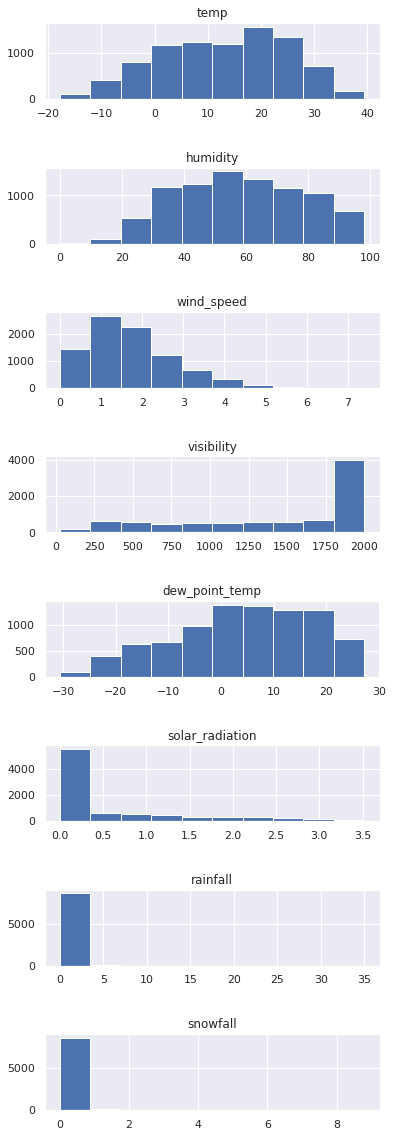

In [19]:
from matplotlib.figure import Figure
fig,axis=plt.subplots(len(columns_to_view),figsize=(6,20))
fig.subplots_adjust(hspace=0.9,wspace=0.3)
for i in range(len(columns_to_view)):
  
  axis[i].set_title(str(columns_to_view[i]))
  axis[i].hist(df[columns_to_view[i]])


In [20]:
# calculating the time span of dataset
print(" The number of days for which the dataset is collected is ",df['date'].max()-df['date'].min())

 The number of days for which the dataset is collected is  364 days 00:00:00


## **Observations about dataset**

*   **This datasetis collected from December 2017 to November 2018 , exactly 364 days. that makes it 1 year of time span**  
*   **This dataset contains 8760 instances and 14 attributes**

## **Data Cleaning and  Feature engineering**

.


**breaking the date column into date , month and year**

In [21]:
df['year']=df['date'].dt.year
df['month']=df['date'].dt.month
df['day']=df['date'].dt.day_name()

In [22]:
df['day'].value_counts()

Friday       1272
Saturday     1248
Sunday       1248
Monday       1248
Tuesday      1248
Wednesday    1248
Thursday     1248
Name: day, dtype: int64

In [23]:
df['weekdays_weekend']=df['day'].apply(lambda elem :1 if elem=='Saturday' or elem=='Sunday' else 0)
df.head(4)

,date,rented_bike_count,hour,temp,humidity,wind_speed,visibility,dew_point_temp,solar_radiation,rainfall,snowfall,seasons,holiday,func_day,year,month,day,weekdays_weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,Friday,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,Friday,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,Friday,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,Friday,0


In [24]:
df=df.drop(['date','year','day'],axis=1)



*   **first we breakdown the `date` column into `day ,month and year`**
*   **we have data from december 2017 to november 2018 , so this is basicaly 1 year of span , so we can ignore this `year` column**

*   **then we splited our days into `weekdays amd weekends` as this make more sense than using all the 7 days as labels, weekdays and wekends can be more helpful. As litreature survey says that generaly we can have more bike sharing in weekdays than weekends**



In [25]:
df['weekdays_weekend'].value_counts()

0    6264
1    2496
Name: weekdays_weekend, dtype: int64

In [26]:
df.groupby(['weekdays_weekend'])['rented_bike_count'].mean()

weekdays_weekend
0    719.448914
1    667.342147
Name: rented_bike_count, dtype: float64

In [27]:
df['holiday'].value_counts()

No Holiday    8328
Holiday        432
Name: holiday, dtype: int64

In [28]:
df.groupby(['holiday'])['rented_bike_count'].mean()

holiday
Holiday       499.756944
No Holiday    715.228026
Name: rented_bike_count, dtype: float64

In [29]:
dependent_var='rented_bike_count'
independent_var=list(set(df.columns)-{dependent_var})
print(independent_var)

['month', 'visibility', 'solar_radiation', 'humidity', 'holiday', 'seasons', 'temp', 'snowfall', 'weekdays_weekend', 'hour', 'dew_point_temp', 'func_day', 'wind_speed', 'rainfall']


In [30]:
for elem in independent_var:
  print(f' {elem}--->{type(df[elem][0])}')

 month---><class 'numpy.int64'>
 visibility---><class 'numpy.int64'>
 solar_radiation---><class 'numpy.float64'>
 humidity---><class 'numpy.int64'>
 holiday---><class 'str'>
 seasons---><class 'str'>
 temp---><class 'numpy.float64'>
 snowfall---><class 'numpy.float64'>
 weekdays_weekend---><class 'numpy.int64'>
 hour---><class 'numpy.int64'>
 dew_point_temp---><class 'numpy.float64'>
 func_day---><class 'str'>
 wind_speed---><class 'numpy.float64'>
 rainfall---><class 'numpy.float64'>


###our litreture survey suggest that dew point temprature **`dew_point_temp`**  and temprature **`temp`** can be highly correlated

*   Lets chcek the relation between **`dew_point_temp`** and **`temp`**

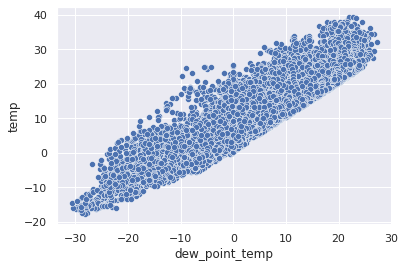

In [31]:
# potting scatterplot between dew point temprature and temprature
sns.scatterplot(x=df['dew_point_temp'],y=df['temp'])

In [32]:

# checking the correlation between dew_point_temp and	temp
df[['dew_point_temp','temp']].corr()

,dew_point_temp,temp
dew_point_temp,1.000000,0.912798
temp,0.912798,1.000000


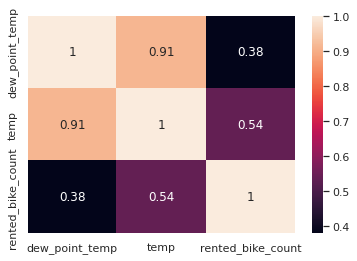

In [33]:
sns.heatmap(df[['dew_point_temp','temp','rented_bike_count']].corr(),annot=True)

*   we can notice that **`dew_point_temp`** is low possitively correlated to **`rented_bike_count`** than **`temp`**, but both have impact on **`rented_bike_count`**` having possitive correlation 

*   so we can try to combine both of them and will more weightage to **`temp`** than **`dew_point_temp`**



In [34]:
# calculating weighted temprature from temp and dew point temp
df['weighted_temp']=0.7*df['temp']+0.3*df['dew_point_temp']

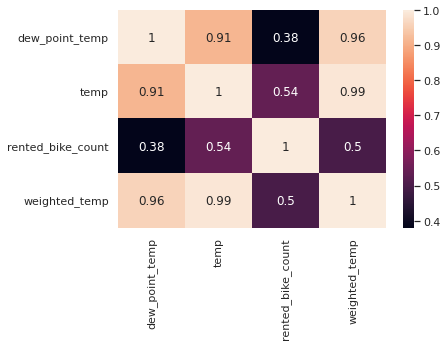

In [35]:
sns.heatmap(df[['dew_point_temp','temp','rented_bike_count','weighted_temp']].corr(),annot=True)

## **Exploratory Data Analysis (EDA)**

**Dependent variable `rented_bike_counts` Anlysis**

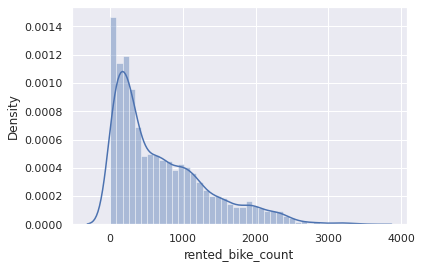

In [36]:
sns.distplot(df[dependent_var])

In [37]:
print(f'The skewness of the dependent variable is {df[dependent_var].skew()} ')

The skewness of the dependent variable is 1.1534281773679014 


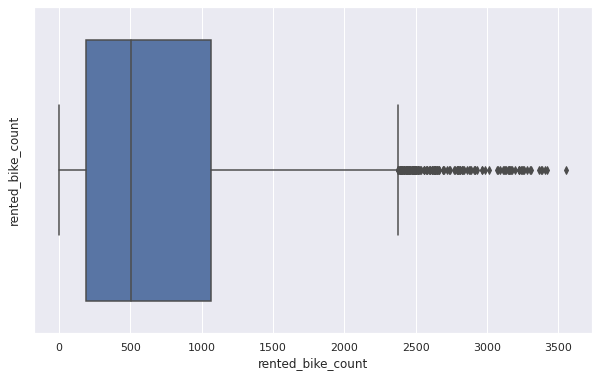

In [38]:
#Boxplot of Rented Bike Count to check outliers
plt.figure(figsize=(10,6))
plt.ylabel('rented_bike_count')
sns.boxplot(x=df['rented_bike_count'])
plt.show()

**observation on original dependent variable**

*   **looks like positively skewed , we can apply log transformation, suare root tranformation  etc. to bring normality**

*  **We have some outliers too in original dependent variable**

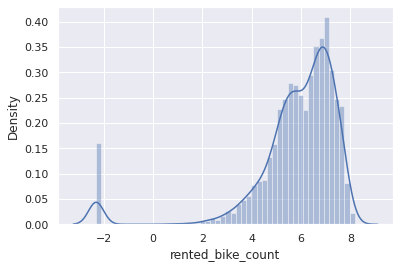

In [39]:
# applying log transformation
sns.distplot(np.log(df[dependent_var]+0.1))

In [40]:
print(f'The skewness of the log transformation is {np.log(df[dependent_var]+0.1).skew()} ')

The skewness of the log transformation is -2.645366561005858 


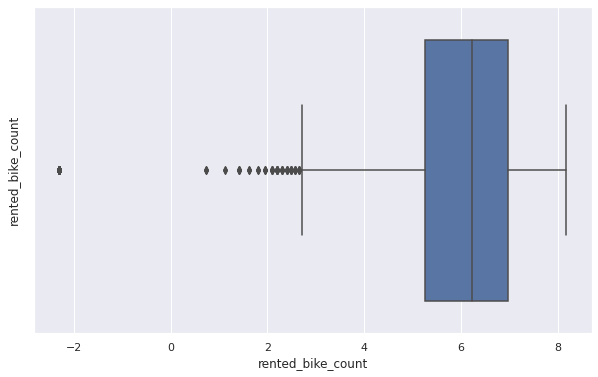

In [41]:
#Boxplot of Rented Bike Count to check outliers
plt.figure(figsize=(10,6))
plt.ylabel('rented_bike_count')
sns.boxplot(x=np.log(df['rented_bike_count']+0.1))
plt.show()

*   **After applying the log tranformation we can notice that the skewness has been increased for the dependent variable also we have some outliers though**


*    **so lets try out square root transformation how it performs**



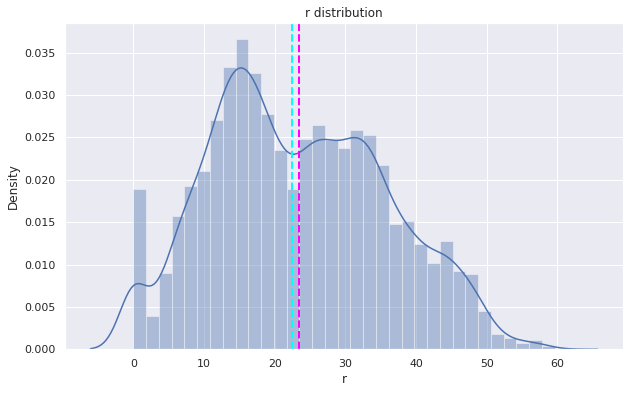

In [42]:
# visualizing the distribution of dependent variable after square root transformation
plt.figure(figsize=(10,6))
sns.distplot(np.sqrt(df[dependent_var]))
plt.xlabel(dependent_var[0])
plt.title(dependent_var[0]+' distribution')
plt.axvline(np.sqrt(df['rented_bike_count']).mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(np.sqrt(df['rented_bike_count']).median(), color='cyan', linestyle='dashed', linewidth=2)

*   **It seems to be more Normal than what we obtained from log tranformation**


In [43]:
# lets check its skewness
print(f'The skewness of the square root transformation is {np.sqrt(df[dependent_var]).skew()} ')

The skewness of the square root transformation is 0.237362090985412 


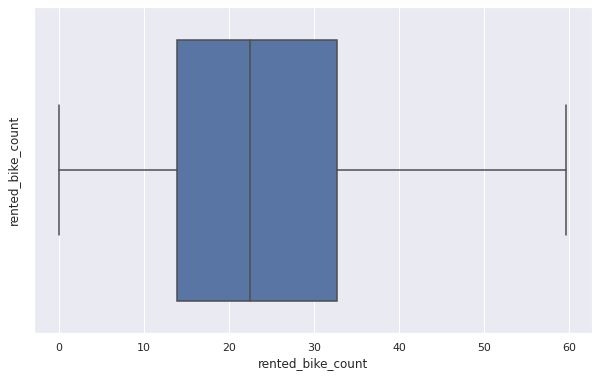

In [44]:
#Boxplot of Rented Bike Count to check outliers
plt.figure(figsize=(10,6))
plt.ylabel('rented_bike_count')
sns.boxplot(x=np.sqrt(df['rented_bike_count']))
plt.show()



*   **It seems to follow normality** 

*   **We dont have any outliers**
*   **Also the skewness is very less than our original dependent variable distribution**
*    **So square root transfromation can be a very good option here**



## **Continuous Independent variable Analyis**

In [45]:
df.columns

Index(['rented_bike_count', 'hour', 'temp', 'humidity', 'wind_speed',
       'visibility', 'dew_point_temp', 'solar_radiation', 'rainfall',
       'snowfall', 'seasons', 'holiday', 'func_day', 'month',
       'weekdays_weekend', 'weighted_temp'],
      dtype='object')

<Figure size 576x360 with 0 Axes>

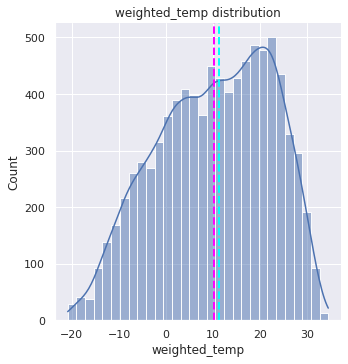

<Figure size 576x360 with 0 Axes>

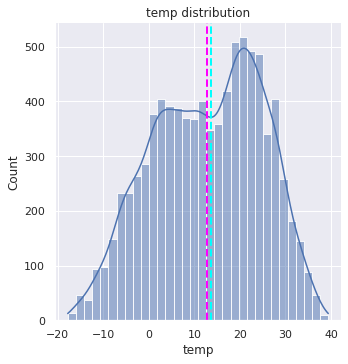

<Figure size 576x360 with 0 Axes>

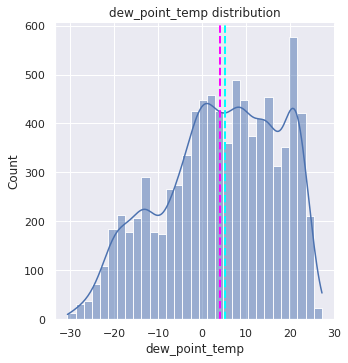

<Figure size 576x360 with 0 Axes>

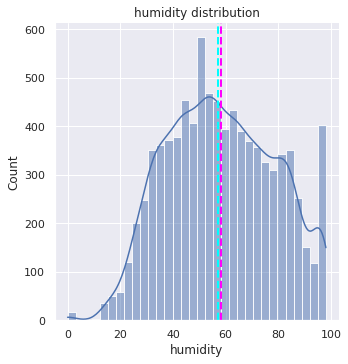

<Figure size 576x360 with 0 Axes>

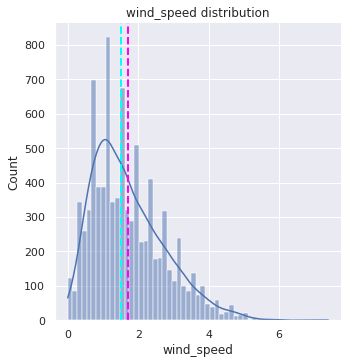

<Figure size 576x360 with 0 Axes>

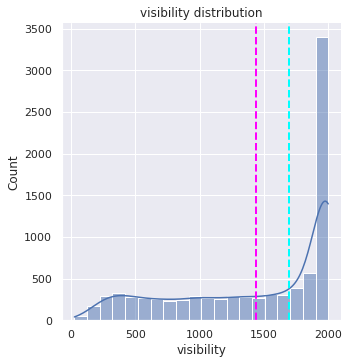

<Figure size 576x360 with 0 Axes>

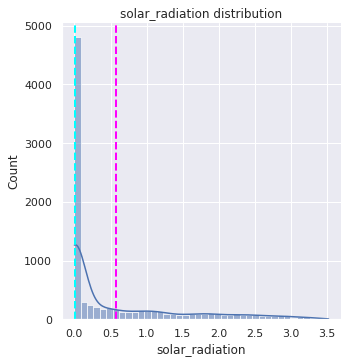

<Figure size 576x360 with 0 Axes>

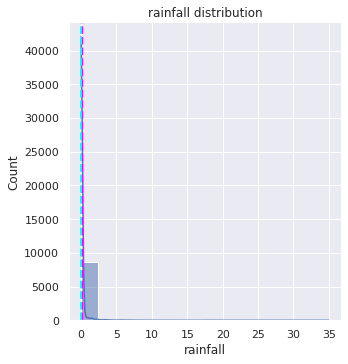

<Figure size 576x360 with 0 Axes>

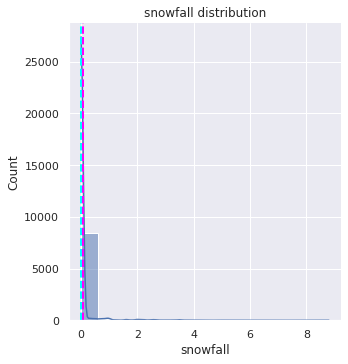

In [46]:
# continuous independent variables can be categorized as
continuous_var = ['weighted_temp','temp','dew_point_temp', 'humidity', 'wind_speed', 'visibility', 'solar_radiation', 'rainfall', 'snowfall']


# ploting the  distributions of the continious variable for the analysis
for elem in continuous_var:
  plt.figure(figsize=(8,5))
  sns.displot(df[elem],kde=True)
  plt.axvline(df[elem].mean(), color='magenta', linestyle='dashed', linewidth=2)
  plt.axvline(df[elem].median(), color='cyan', linestyle='dashed', linewidth=2)
  plt.title(elem+' distribution')


### **we can notice from the above plot that**

*    **Weighted temprature (weighted_temp) and humidity are normaly distributed**
*    **wind_speed , snowfall, rainfall , solar_radiation are positively skewed**
*    **visibility is negetively skewed**



## **Relationship of continous independent variable and dependent variable**

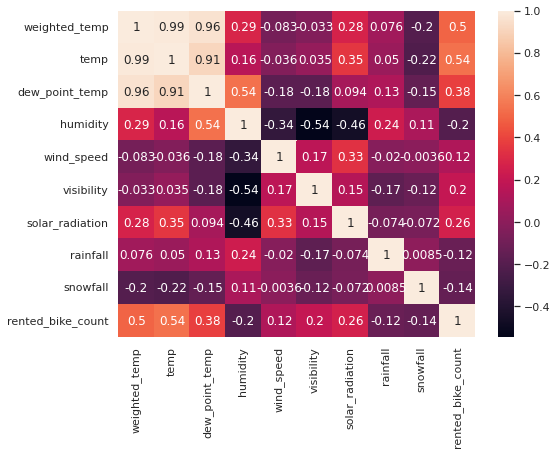

In [47]:
# heatmap for the continous variables  in order to understand the relationship with dependent variable
plt.figure(figsize=(8,6))
sns.heatmap(df[continuous_var+['rented_bike_count']].corr(),annot=True)



*   **`snowfall`, `rainfall`and `humidity`** is negetively correlated with the dependent variable **`rented_bike_count`**
*   **`weighted_temp`, `wind_speed`, `visibility` and `solar_radiation`** is positively correlated with dependent variable **`rented_bike_count`**



## **Analysis of Independent Categorical Variable**

In [48]:
categorical=['seasons','holiday','hour','func_day','month','weekdays_weekend']


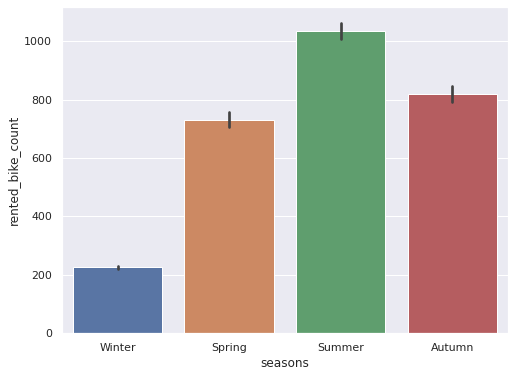

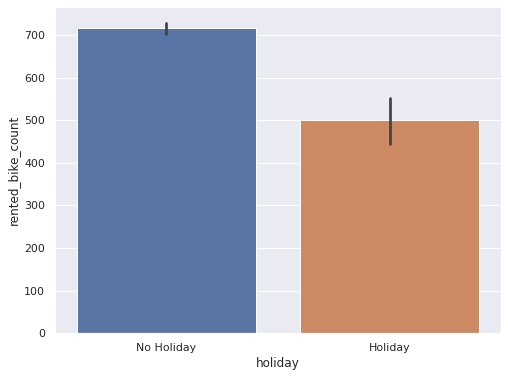

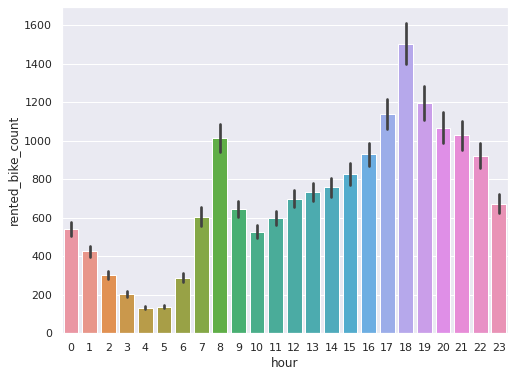

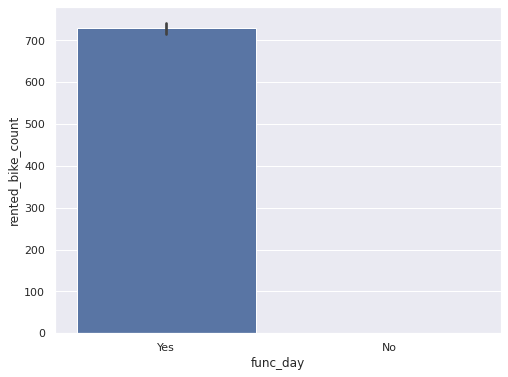

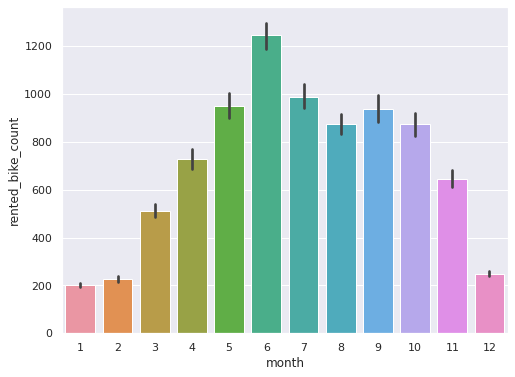

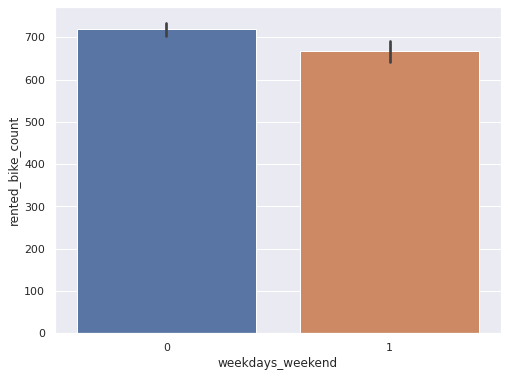

In [49]:
for col in categorical:
  plt.figure(figsize=(8,6))
  sns.barplot(x=df[col],y=df['rented_bike_count'])
  

## **Observations on Categorical Variable relashionship with dependent variable**

*   **Seasons** - In summer season we have high demand rented bikes

*   **Holiday** - In No holdiay we have high demand of rented bikes

*   **Hour** - In morning time 7:00 AM to 9:00 AM we have high demand possible reason could be office time , In evening 4:00 PM to 10:00 PM we have high demand of rented bikes

*   **Func_day** - In functioning day we have very high demand and in non-functioning day we approximately no demand of rented bikes

*   **Month** - From june to october we have high demand of rented bikes

*   **weekdays_weekend** - In weekdays we high demand of rented bikes

**Lets confirm the that we have approximately no demand of rented bikes in Non-functioning day**

In [50]:
# calculating the max value rented bikes count in Non functioning day and functioning day
df.groupby(['func_day'])['rented_bike_count'].max()

func_day
No        0
Yes    3556
Name: rented_bike_count, dtype: int64



*   **So, we have no bikes demand on non-functioning day**

*   **func_day can be a important feature to predict the rented bike count**



## **Data Preprocessing**

*  ## **Outliers analyis**

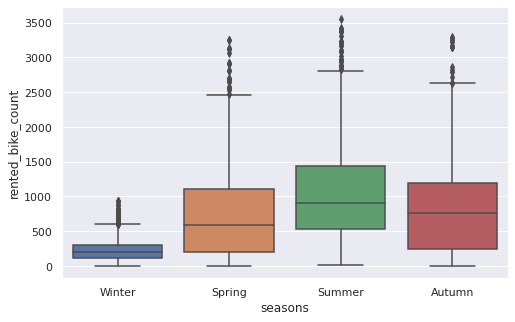

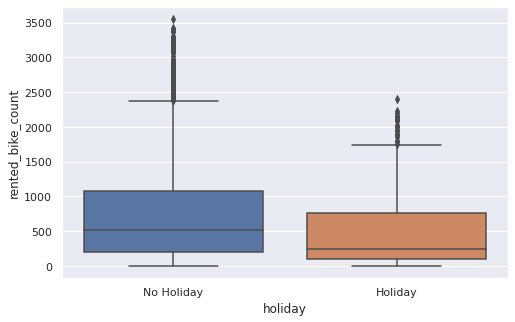

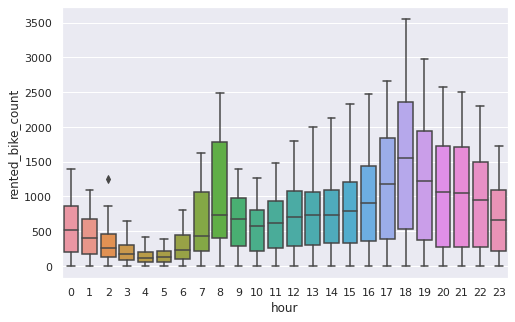

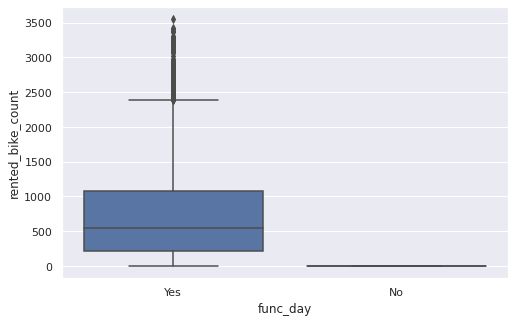

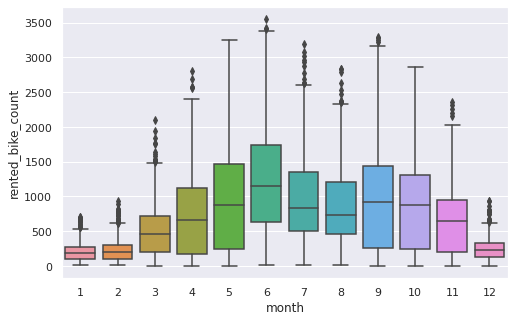

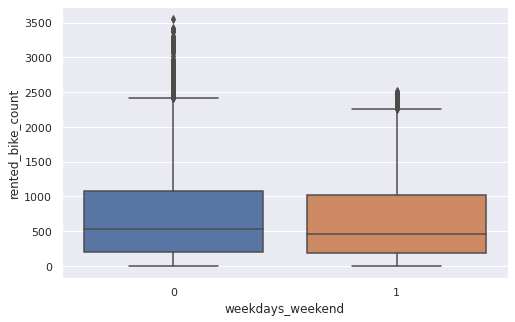

In [51]:
for elem in categorical:
  plt.figure(figsize=(8,5))
  sns.boxplot(x=elem, y=dependent_var,data=df) 

*   **There are outliers in the many categorical_variable , which need to handled before going for model prediction**

## **We can convert the snowfall and rainfall  into categorical features**

In [52]:
# Converting snowfall and rainfall to categorical attributes
df['snowfall'] = df['snowfall'].apply(lambda i: 1 if i>0 else 0)
df['rainfall'] = df['rainfall'].apply(lambda i: 1 if i>0 else 0)


## **Droping temp and dew point temp**

*   **As we have calculated weighted tempature using both temp and dew point temp**

In [53]:
df=df.drop(['dew_point_temp'],axis=1)

## **Applying One-Hot Encoding on categorical variables**

In [54]:
df.columns

Index(['rented_bike_count', 'hour', 'temp', 'humidity', 'wind_speed',
       'visibility', 'solar_radiation', 'rainfall', 'snowfall', 'seasons',
       'holiday', 'func_day', 'month', 'weekdays_weekend', 'weighted_temp'],
      dtype='object')

**we have seasons which is group of months , so we need to decide which one to keep**

*   **keeping seasons will make model less complex , so we can take seasons intead of month**

In [55]:
nominal_var=['seasons','holiday','hour','func_day','month']

# One hot encoding for categorical (nominal variables)

df=pd.get_dummies(df,columns=nominal_var)
df.columns


Index(['rented_bike_count', 'temp', 'humidity', 'wind_speed', 'visibility',
       'solar_radiation', 'rainfall', 'snowfall', 'weekdays_weekend',
       'weighted_temp', 'seasons_Autumn', 'seasons_Spring', 'seasons_Summer',
       'seasons_Winter', 'holiday_Holiday', 'holiday_No Holiday', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'func_day_No',
       'func_day_Yes', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'],
      dtype='object')

In [56]:
#df=df.drop(['month'],axis=1)

## **Defining Variables for Training**

In [57]:
independent_features=list(set(df.columns) -{'rented_bike_count'})
dependent_feature=['rented_bike_count']

In [58]:
# Defining dependent and independent variables
X = df.drop('rented_bike_count',axis=1)

# applying squareroot transformation on rented_bike_count
y = np.sqrt(df['rented_bike_count'])

In [59]:
pd.set_option('display.max_columns',None)
X.head(3)

,temp,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,weekdays_weekend,weighted_temp,seasons_Autumn,seasons_Spring,seasons_Summer,seasons_Winter,holiday_Holiday,holiday_No Holiday,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,func_day_No,func_day_Yes,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-5.2,37,2.2,2000,0.0,0,0,0,-8.92,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,-5.5,38,0.8,2000,0.0,0,0,0,-9.13,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,-6.0,39,1.0,2000,0.0,0,0,0,-9.51,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [61]:
X.shape

(8760, 53)

## **Model selection process**

In [62]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)


### **Definig RMSE metric score**

In [63]:
# defining rmse evaluation metric
def rmse(actual,pred):
  '''
  rmse(actual_y,predicted_y)
  '''
  mse = mean_squared_error(actual,pred)
  return np.sqrt(mse)

## **Decision Tree with Default Parameters**

In [ ]:
# rough code 

dt_model=DecisionTreeRegressor(random_state=0)
dt_model.fit(X_train,y_train)
dt_model_pred=dt_model.predict(X_test)
dt_model_test_r2=r2_score(np.square(y_test),np.square(dt_model_pred))
print(dt_model_test_r2)

dt_model_pred=dt_model.predict(X_train)
dt_model_train_r2=r2_score(np.square(y_train),np.square(dt_model_pred))
print(dt_model_train_r2)

0.8267765139067792
1.0


In [ ]:
dt_model.tree_.max_depth

45

## **HyperParameter tunning Decision Tree**

In [ ]:
# Using gridsearchcv to find the hyperparameters with best predictions
# A full grown tree has a max depth of 28.
DT = DecisionTreeRegressor(random_state=0)
DT_params = {
             'max_depth':np.arange(26,48,2),
             'min_samples_leaf':np.arange(4,12),
             'max_features':np.arange(4,26)
             }

# fitting model with hypertuned paramaters using grid search
DT_gridsearch = GridSearchCV(DT,
                             DT_params,
                             cv=3,
                             scoring= 'neg_root_mean_squared_error')
DT_gridsearch.fit(X_train,y_train)
DT_best_params = DT_gridsearch.best_params_

# model best parameters
DT_best_params

{'max_depth': 28, 'max_features': 24, 'min_samples_leaf': 4}

In [ ]:
DT_model = DecisionTreeRegressor(
                                 max_depth=DT_best_params['max_depth'],
                                 min_samples_leaf=DT_best_params['min_samples_leaf'],
                                 max_features=DT_best_params['max_features'],
                                 random_state=0)
DT_model.fit(X_train,y_train)
DT_train_pred = DT_model.predict(X_train)
DT_test_pred = DT_model.predict(X_test)

from sklearn.metrics import r2_score

# train score
DT_train_r2_score = r2_score(np.square(y_train),np.square(DT_train_pred))
DT_train_r2_score


0.9495879120620415

In [ ]:
# test score
DT_test_r2_score = r2_score(np.square(y_test),np.square(DT_test_pred))
DT_test_r2_score


0.8423009662402081

## **Feature Importance**

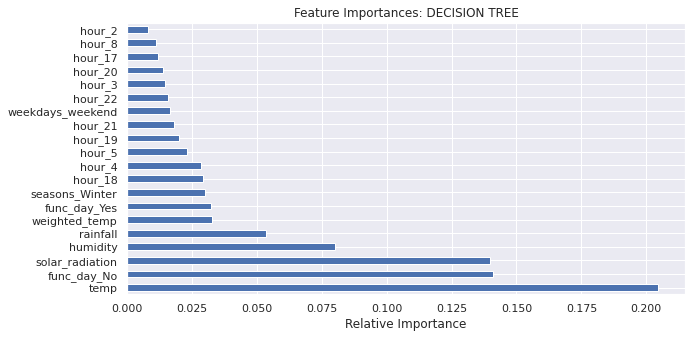

In [ ]:
# Feature importances

dt_feat_imp = pd.Series(DT_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,5))
plt.title('Feature Importances: DECISION TREE')
plt.xlabel('Relative Importance')
dt_feat_imp.nlargest(20).plot(kind='barh')

## **Random Forest with Default Parameters**

In [ ]:
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
reg_preds_train =  reg.predict(X_train)
reg_preds_test  = reg.predict(X_test)
r2_score(np.square(y_train),np.square(reg_preds_train))

0.9891868427842291

In [ ]:
r2_score(np.square(y_test),np.square(reg_preds_test))

0.9109800144952369

## **Random forest with Hypertunning**

In [ ]:
opt = BayesSearchCV(
    RandomForestRegressor(random_state=42),
    {
        'n_estimators': (5,1000),
        'max_features': ['auto','sqrt'],
        'max_depth': (2,70),
        'min_samples_split': (2,50),
        'min_samples_leaf': (1,50),
        'bootstrap': ["True","False"]
    },
    n_iter=32,
    cv=3,
    scoring='neg_root_mean_squared_error'
)
opt.fit(X_train,y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test,y_test))



val. score: -3.4773279062481346
test score: -3.5254866457812004


In [ ]:
# best parameters
opt.best_params_

OrderedDict([('bootstrap', 'False'),
             ('max_depth', 70),
             ('max_features', 'auto'),
             ('min_samples_leaf', 1),
             ('min_samples_split', 2),
             ('n_estimators', 1000)])

In [68]:
reg_model = RandomForestRegressor(n_estimators=1000,       #opt.best_params_['n_estimators'],
                                     min_samples_leaf=1,    #opt.best_params_['min_samples_leaf'],
                                     min_samples_split=2,    #opt.best_params_['min_samples_split'],
                                     max_depth=7,     # pruning the max_depth here       #opt.best_params_['max_depth'],
                                     max_features='auto',      #opt.best_params_['max_features'],
                                     bootstrap= False,            #opt.best_params_['bootstrap'],
                                     random_state=0)
reg_model=reg_model.fit(X_train,y_train)
reg_preds_train =  reg_model.predict(X_train)
reg_preds_test  = reg_model.predict(X_test)
print('RANDOM FOREST R2 score for training : ',r2_score(np.square(y_train),np.square(reg_preds_train)))
print('RANDOM FOREST R2 score for training : ',r2_score(np.square(y_test),np.square(reg_preds_test)))

RANDOM FOREST R2 score for training :  0.6529419139367452
RANDOM FOREST R2 score for training :  0.6253742977361959


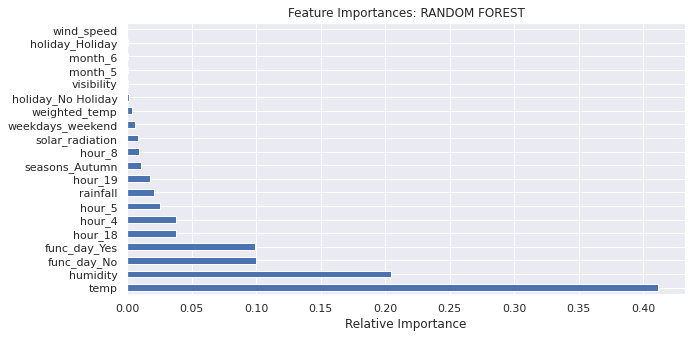

In [69]:
# Feature importances

dt_feat_imp = pd.Series(reg_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,5))
plt.title('Feature Importances: RANDOM FOREST')
plt.xlabel('Relative Importance')
dt_feat_imp.nlargest(20).plot(kind='barh')

## **Gradient Boosting**

In [ ]:
gb_model = GradientBoostingRegressor(random_state=0)
gb_model.fit(X_train,y_train)
gb_y_train_pred = gb_model.predict(X_train)
gb_y_test_pred = gb_model.predict(X_test)
gb_train_r2_score = r2_score(np.square(y_train),np.square(gb_y_train_pred))
print('DEFFAULT GRADIENT BOOSTING TRAINIG R2 SCORE',gb_train_r2_score)
gb_test_r2_score = r2_score(np.square(y_test),np.square(gb_y_test_pred))

print('DEFFAULT GRADIENT BOOSTING Test R2 SCORE',gb_test_r2_score)

DEFFAULT GRADIENT BOOSTING TRAINIG R2 SCORE 0.8445627774507125
DEFFAULT GRADIENT BOOSTING Test R2 SCORE 0.8346112284739757


## **Hyperparameter tunning for Gradient Boosting**

In [ ]:
grad_opt = BayesSearchCV(
    GradientBoostingRegressor(random_state=42),
    {
        'n_estimators': (5,1000),
        'max_features': ['auto','sqrt'],
        'max_depth': (2,70),
        'min_samples_split': (2,50),
        'min_samples_leaf': (1,50)
        
    },
    n_iter=32,
    cv=3,
    scoring='neg_root_mean_squared_error'
)
grad_opt.fit(X_train,y_train)
# best parameters
grad_opt.best_params_

{'max_depth': 12,
 'min_samples_leaf': 40,
 'min_samples_split': 40,
 'n_estimators': 600}

In [70]:
from scipy.stats import bootstrap
gb_model = GradientBoostingRegressor(n_estimators=1000,         #grad_opt.best_params_['n_estimators'],
                                     min_samples_leaf=1,        #grad_opt.best_params_['min_samples_leaf'],
                                     min_samples_split=4,       #grad_opt.best_params_['min_samples_split'],
                                     max_depth=5,        # pruning max_depth to 5 for reducing the overfitting      #grad_opt.best_params_['max_depth'],
                                     max_features='auto',
                                     random_state=0)

gb_model.fit(X_train,y_train)
gb_y_train_pred = gb_model.predict(X_train)
gb_y_test_pred = gb_model.predict(X_test)
gb_train_r2_score = r2_score(np.square(y_train),np.square(gb_y_train_pred))
gb_train_r2_score

0.9935291596627511

In [71]:
gb_test_r2_score = r2_score(np.square(y_test),np.square(gb_y_test_pred))
gb_test_r2_score

0.9333838953545955

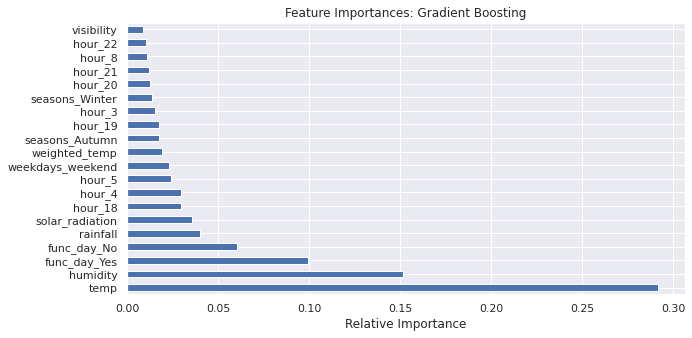

In [72]:
# Feature importances

dt_feat_imp = pd.Series(gb_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,5))
plt.title('Feature Importances: Gradient Boosting')
plt.xlabel('Relative Importance')
dt_feat_imp.nlargest(20).plot(kind='barh')

## **XGBOOST**

In [64]:
# default model parameters
xgb_model = xgb.XGBRegressor(n_estimators=1000, random_state=0)

# fit
xgb_model.fit(X_train,y_train)
xgb_y_train_pred = xgb_model.predict(X_train)
xgb_y_test_pred = xgb_model.predict(X_test)

# train score
xgb_train_r2_score = r2_score(np.square(y_train),np.square(xgb_y_train_pred))
print('XGboost default training R2 score ',xgb_train_r2_score)

# test score
xgb_test_r2_score = r2_score(np.square(y_test),np.square(xgb_y_test_pred))
print('XGboost default testing R2 score ',xgb_test_r2_score)

[09:43:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGboost default training R2 score  0.9592026577094177
XGboost default testing R2 score  0.9215792477689373


## **Hyperparameter tunning for XGboost**

In [ ]:
# xg boost
xgb_model = xgb.XGBRegressor(random_state=0,
                             objective='reg:squarederror')



# HYperparameter Grid
xgb_params = {'n_estimators' : [500,600],
              'max_depth' : [8,10,12],
              'min_samples_split' : [40,45,50],
              'min_samples_leaf' : [35,40]}


xgb_gridsearch = GridSearchCV(xgb_model,xgb_params,cv=3,scoring='neg_root_mean_squared_error')
xgb_gridsearch.fit(X_train,y_train)
xgb_best_params = xgb_gridsearch.best_params_
xgb_best_params



{'max_depth': 8,
 'min_samples_leaf': 35,
 'min_samples_split': 40,
 'n_estimators': 600}

In [ ]:
# Building a XG boost model with best parameters
xgb_model = xgb.XGBRegressor(n_estimators=1000,                  #using grad_opt.best_params_['n_estimators']
                                     min_samples_leaf=1,         #using grad_opt.best_params_['min_samples_leaf']
                                     min_samples_split=4,        #using grad_opt.best_params_['min_samples_split']
                                     max_depth=5,                # pruning max_depth to 5 for reducing the overfitting     
                                     max_features='auto',
                                     random_state=0)

# fit
xgb_model.fit(X_train,y_train)
xgb_y_train_pred = xgb_model.predict(X_train)
xgb_y_test_pred = xgb_model.predict(X_test)

xgb_train_r2_score = r2_score(np.square(y_train),np.square(xgb_y_train_pred))
xgb_train_r2_score

[15:53:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9924108410245405

In [ ]:
# test score
xgb_test_r2_score = r2_score(np.square(y_test),np.square(xgb_y_test_pred))
xgb_test_r2_score

0.9337981166608972

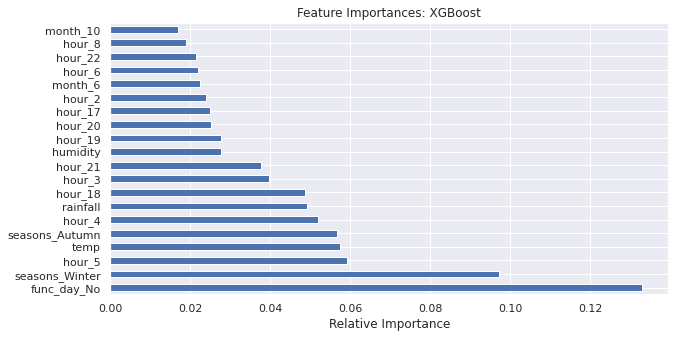

In [73]:
# Feature importances

dt_feat_imp = pd.Series(xgb_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,5))
plt.title('Feature Importances: XGBoost')
plt.xlabel('Relative Importance')
dt_feat_imp.nlargest(20).plot(kind='barh')

## **AdaBoost**

In [75]:
from sklearn.ensemble import AdaBoostRegressor

# Building a adaboost model with best parameters
adaboost_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=23), n_estimators=10, learning_rate=1.0, loss='linear', random_state=0)

# fit
adaboost_model.fit(X_train,y_train)
adaboost_y_train_pred = adaboost_model.predict(X_train)
adaboost_y_test_pred = adaboost_model.predict(X_test)

adaboost_train_r2_score = r2_score(np.square(y_train),np.square(adaboost_y_train_pred))
print('training R2 score',adaboost_train_r2_score)
adaboost_test_r2_score = r2_score(np.square(y_test),np.square(adaboost_y_test_pred))
print('testing R2 score',adaboost_test_r2_score)

training R2 score 0.9970894831523082
testing R2 score 0.9131833185984044


## **Hyperparameter tunning for adaboost**

In [ ]:
grad_opt = BayesSearchCV(
    AdaBoostRegressor(random_state=42),
    {
        'n_estimators': (5,500),
        'base_estimator': [DecisionTreeRegressor(max_depth=i) for i in np.arange(2,50)],
        'learning_rate': np.arange(0.1, 2.1, 0.1),
        'loss':['linear','square']
        
        
    },
    n_iter=32,
    cv=3,
    scoring='neg_root_mean_squared_error'
)
grad_opt.fit(X_train,y_train)
# best parameters
grad_opt.best_params_

OrderedDict([('base_estimator', DecisionTreeRegressor(max_depth=48)),
             ('learning_rate', 0.9),
             ('loss', 'square'),
             ('n_estimators', 500)])

In [83]:
adaboost_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=48), n_estimators=500, learning_rate=0.9, loss='square', random_state=0)

# fit
adaboost_model.fit(X_train,y_train)
adaboost_y_train_pred = adaboost_model.predict(X_train)
adaboost_y_test_pred = adaboost_model.predict(X_test)

adaboost_train_r2_score = r2_score(np.square(y_train),np.square(adaboost_y_train_pred))
print('training R2 score',adaboost_train_r2_score)
adaboost_test_r2_score = r2_score(np.square(y_test),np.square(adaboost_y_test_pred))
print('testing R2 score',adaboost_test_r2_score)

training R2 score 0.998351825791799
testing R2 score 0.9246467135074241


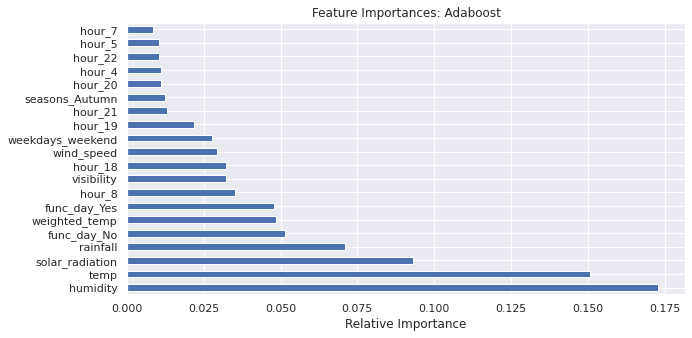

In [84]:
# Feature importances

dt_feat_imp = pd.Series(adaboost_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,5))
plt.title('Feature Importances: Adaboost')
plt.xlabel('Relative Importance')
dt_feat_imp.nlargest(20).plot(kind='barh')

In [67]:
# displaying the results of evaluation metric values for all models
models=['Decision tree default', 'Decsion tree tunned','Random forest deafult','Random forest tunned','Gradient boosting default','Gradient boosting tunned','XGboost default','XGboost tunned','Adaboost default','Adaboost tunned']
test_result=[0.8267,0.8423,0.91098,0.6253,0.83461,0.93338,0.92157,0.93379,0.99922,0.92952]
train_result=[1.0,0.9495,0.98918,0.65294,0.84456,0.99352,0.95920,0.992410,0.89753,0.99842]

data={"models":models,'TRAINING R2 score':train_result,'TEST R2 score':test_result}
results=pd.DataFrame(data)
results

,models,TRAINING R2 score,TEST R2 score
0,Decision tree default,1.00000,0.82670
1,Decsion tree tunned,0.94950,0.84230
2,Random forest deafult,0.98918,0.91098
3,Random forest tunned,0.65294,0.62530
4,Gradient boosting default,0.84456,0.83461
5,Gradient boosting tunned,0.99352,0.93338
6,XGboost default,0.95920,0.92157
7,XGboost tunned,0.99241,0.93379
8,Adaboost default,0.89753,0.99922
9,Adaboost tunned,0.99842,0.92952


## **Conclusions**


*   **XG Boost and Gradient Boosting tunned model are giving best results**
*   List item

